In [1]:
import shifterator as sh
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import spacy
import ast

nltk.download('punkt')
nltk.download('stopwords')

2023-06-08 00:12:42.937671: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/martagracia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/martagracia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
articles_num_agr_proba = pd.read_csv('../articles_classification/articles_num_agr_proba.csv', index_col=0)
articles_num_agr_proba.head()

,tweet_id,media,title,headline,url,article,publication_date,text,prob_individual,prob_grupal,prob_otros,label_predict
0,1212203735650328577,20m,name britanica detenida falso testimonio tras ...,name joven britanica 19 anos mes julio detenida,https://www.20minutos.es/noticia/4102525/0/cul...,name joven britanica 19 anos mes julio detenid...,2019-12-31,name britanica detenida falso testimonio tras ...,0.535321,0.214872,0.249806,0
1,1212467642428280832,20m,name parto nina 13 anos violada padre,name name nina brasilena 13 anos fallecio comi...,https://www.20minutos.es/noticia/4103250/0/mue...,name name nina brasilena 13 anos fallecio comi...,2020-01-01,name parto nina 13 anos violada padre name nam...,0.905729,0.040321,0.053950,0
2,1212826760234127360,20m,name 3 jovenes acusados violar 3 hermanas esta...,name name name detenido jueves tres jovenes ac...,https://www.20minutos.es/noticia/4104199/0/det...,name name name detenido jueves tres jovenes ac...,2020-01-02,name 3 jovenes acusados violar 3 hermanas esta...,0.357639,0.565110,0.077251,1
3,1213232973715267584,20m,name claves name juicio name name abusos sexua...,name juicio supuestos abusos sexuales todopode...,https://www.20minutos.es/noticia/4105188/0/cla...,name juicio supuestos abusos sexuales todopode...,2020-01-03,name claves name juicio name name abusos sexua...,0.236147,0.033098,0.730755,2
4,1213348259076415488,20m,name name name investiga escritor frances name...,name name name abierto viernes investigacion e...,https://www.20minutos.es/noticia/4104916/0/fra...,name name name abierto viernes investigacion e...,2020-01-03,name name name investiga escritor frances name...,0.864866,0.066744,0.068390,0


In [3]:
articles_agr = articles_num_agr_proba[articles_num_agr_proba['label_predict'] != 2]
articles_agr = articles_agr[['text', 'label_predict']]

In [4]:
# Split the DataFrame based on the label
label_0 = articles_agr[articles_agr['label_predict']==0]
label_1 = articles_agr[articles_agr['label_predict']==1]

### Basic tokanization

In [5]:
stopwords = stopwords.words('spanish')

In [6]:
def preprocess(text):
    result = []
    tokens = nltk.word_tokenize(text, language='spanish')
    for token in tokens:
        if token.lower() not in stopwords and len(token) > 3:
            result.append(token)
    return result

In [7]:
# Tokenize and preprocess the text
label_0['text_tokenized'] = label_0['text'].apply(lambda x: preprocess(x))
label_0['text_tokenized'] = label_0['text_tokenized'].apply(lambda tokens: [token for token in tokens if token != 'name'])

label_1['text_tokenized'] = label_1['text'].apply(lambda x: preprocess(x))
label_1['text_tokenized'] = label_1['text_tokenized'].apply(lambda tokens: [token for token in tokens if token != 'name'])

/var/folders/8y/kdv5k1ks43v38hl9433hbqsr0000gn/T/ipykernel_13689/3792360304.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_0['text_tokenized'] = label_0['text'].apply(lambda x: preprocess(x))
/var/folders/8y/kdv5k1ks43v38hl9433hbqsr0000gn/T/ipykernel_13689/3792360304.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_0['text_tokenized'] = label_0['text_tokenized'].apply(lambda tokens: [token for token in tokens if token != 'name'])
/var/folders/8y/kdv5k1ks43v38hl9433hbqsr0000gn/T/ipykernel

In [8]:
# Unir todas las frases tokenizadas en un mismo array
tokens_label_0 = sum(label_0['text_tokenized'], [])
tokens_label_1 = sum(label_1['text_tokenized'], [])

In [9]:
print('tokens_label_0:',len(tokens_label_0))
print('tokens_label_1:', len(tokens_label_1))

tokens_label_0: 2579703
tokens_label_1: 395691


# Basic Shiferator

In [10]:
# Calculate frequency counts
type2freq_0 = Counter(tokens_label_0)
type2freq_1 = Counter(tokens_label_1)

1. Proportion Shifts (Cambios de Proporciones): Esta métrica mide los cambios en las proporciones relativas de diferentes categorías en la distribución de los datos. Proporciona una medida simple y directa de cómo cambian las proporciones entre las categorías en comparación con una distribución de referencia.

/Users/martagracia/Library/Python/3.9/lib/python/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


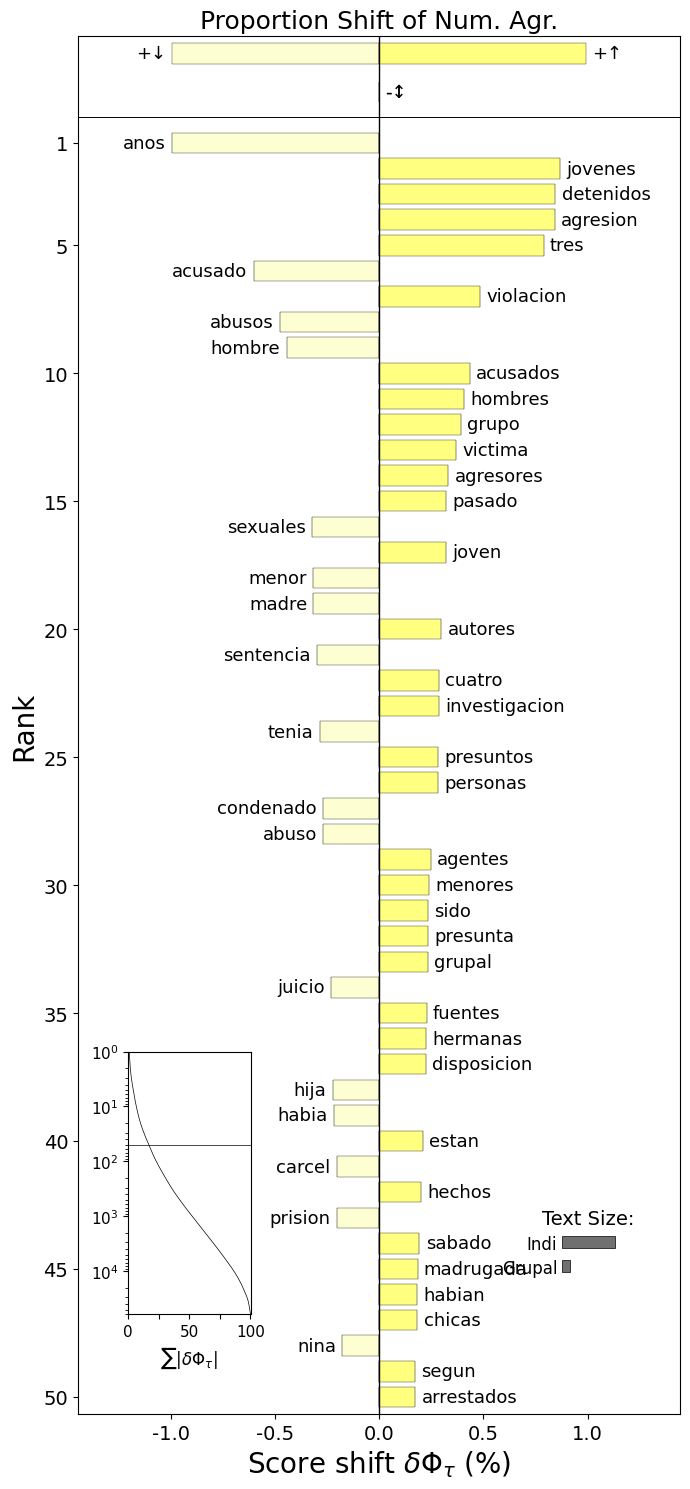

In [11]:
# Create a ProportionShift object
proportion_shift = sh.ProportionShift(type2freq_1=type2freq_0, type2freq_2=type2freq_1)

# Generate the shift graph
shift_graph = proportion_shift.get_shift_graph(detailed=True, system_names=['Indi', 'Grupal'], title='Proportion Shift of Num. Agr.')

2. Shannon Entropy Shifts (Cambios en la Entropía de Shannon): La Entropía de Shannon es una medida de la incertidumbre o desorden en una distribución de probabilidad. Los cambios en la Entropía de Shannon indican cómo la estructura de las probabilidades ha cambiado en comparación con la distribución de referencia. Esta métrica captura los cambios en la diversidad o dispersión de las categorías en los datos.

/Users/martagracia/Library/Python/3.9/lib/python/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


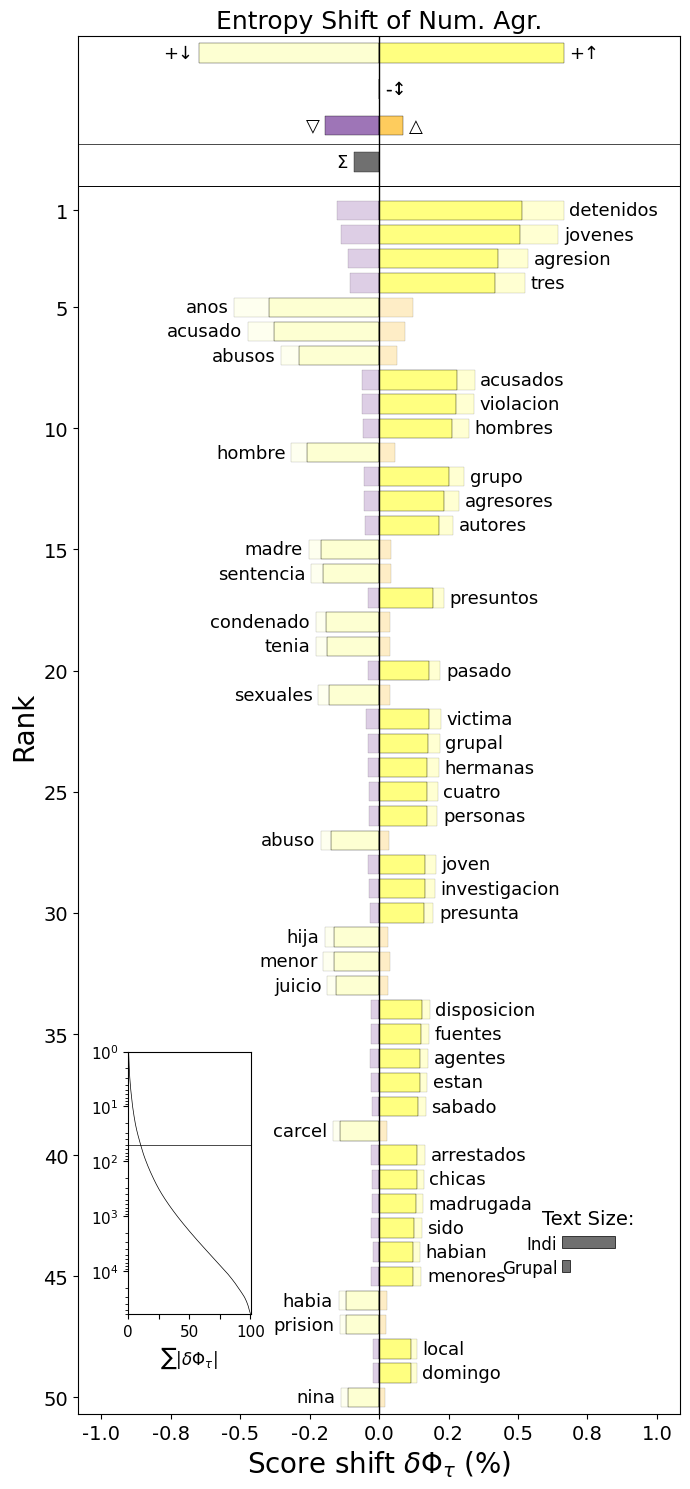

In [12]:
# Create a entropy_shift object
entropy_shift = sh.EntropyShift(type2freq_1=type2freq_0,
                                type2freq_2=type2freq_1,
                                base=2)
# Generate the shift graph
shift_graph = entropy_shift.get_shift_graph(detailed=True, system_names=['Indi', 'Grupal'], title='Entropy Shift of Num. Agr.')

3. Tsallis Entropy Shifts (Cambios en la Entropía de Tsallis): Similar a la Entropía de Shannon, la Entropía de Tsallis es otra medida de la incertidumbre o desorden en una distribución de probabilidad. Sin embargo, la Entropía de Tsallis generaliza la Entropía de Shannon al introducir un parámetro adicional que controla el grado de sensibilidad a las colas de la distribución. Los cambios en la Entropía de Tsallis proporcionan una medida más flexible de cómo la estructura de las probabilidades ha cambiado en comparación con la distribución de referencia.


/Users/martagracia/Library/Python/3.9/lib/python/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


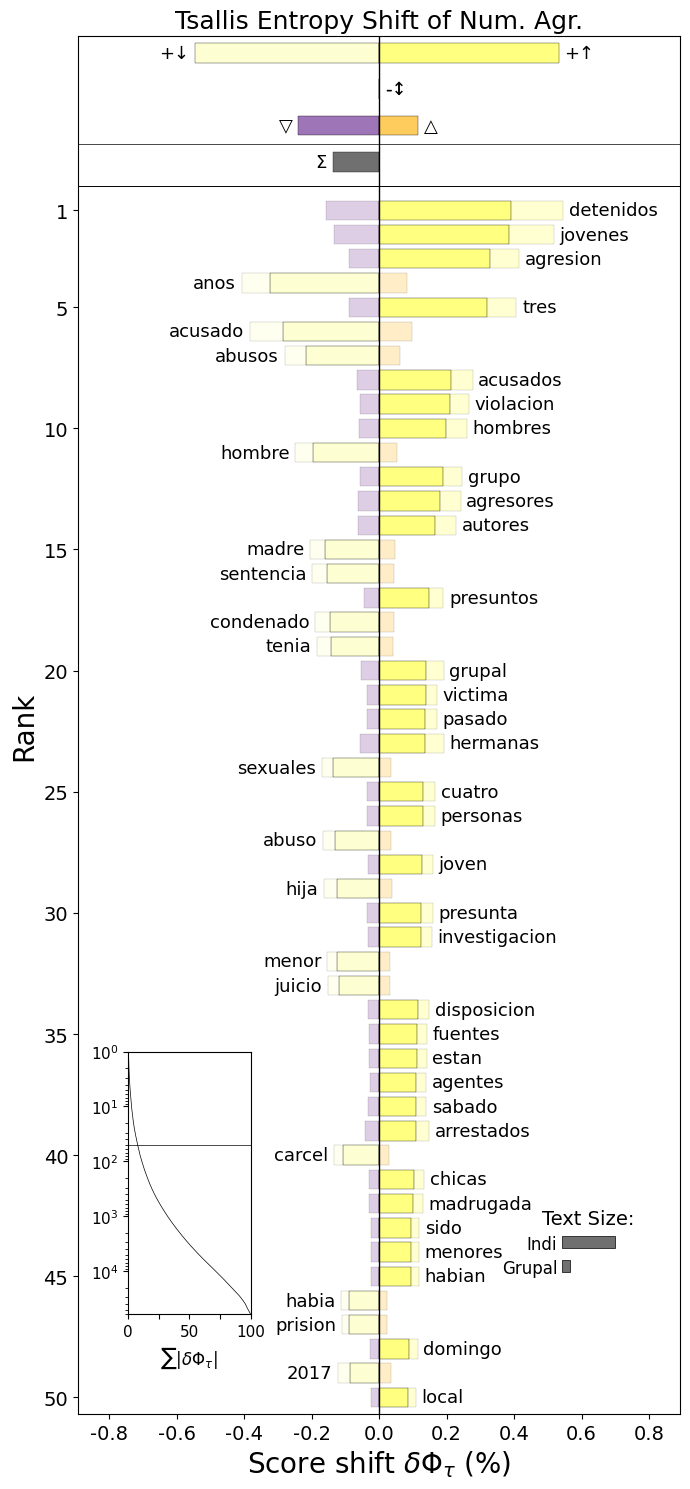

In [13]:
# Create a Tsallis entropy_shift object
entropy_shift = sh.EntropyShift(type2freq_1=type2freq_0,
                                type2freq_2=type2freq_1,
                                base=2,
                                alpha=0.8)
# Generate the shift graph
shift_graph = entropy_shift.get_shift_graph(detailed=True, system_names=['Indi', 'Grupal'], title='Tsallis Entropy Shift of Num. Agr.')

4. Kullback-Leibler Divergence Shifts (Cambios en la Divergencia de Kullback-Leibler): La Divergencia de Kullback-Leibler (KL) es una medida que cuantifica la diferencia entre dos distribuciones de probabilidad. Los cambios en la Divergencia de KL indican cómo la distribución de los datos se ha alejado de la distribución de referencia en términos de información relativa. Esta métrica proporciona una medida de la distancia entre las distribuciones de probabilidad.


/Users/martagracia/Library/Python/3.9/lib/python/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


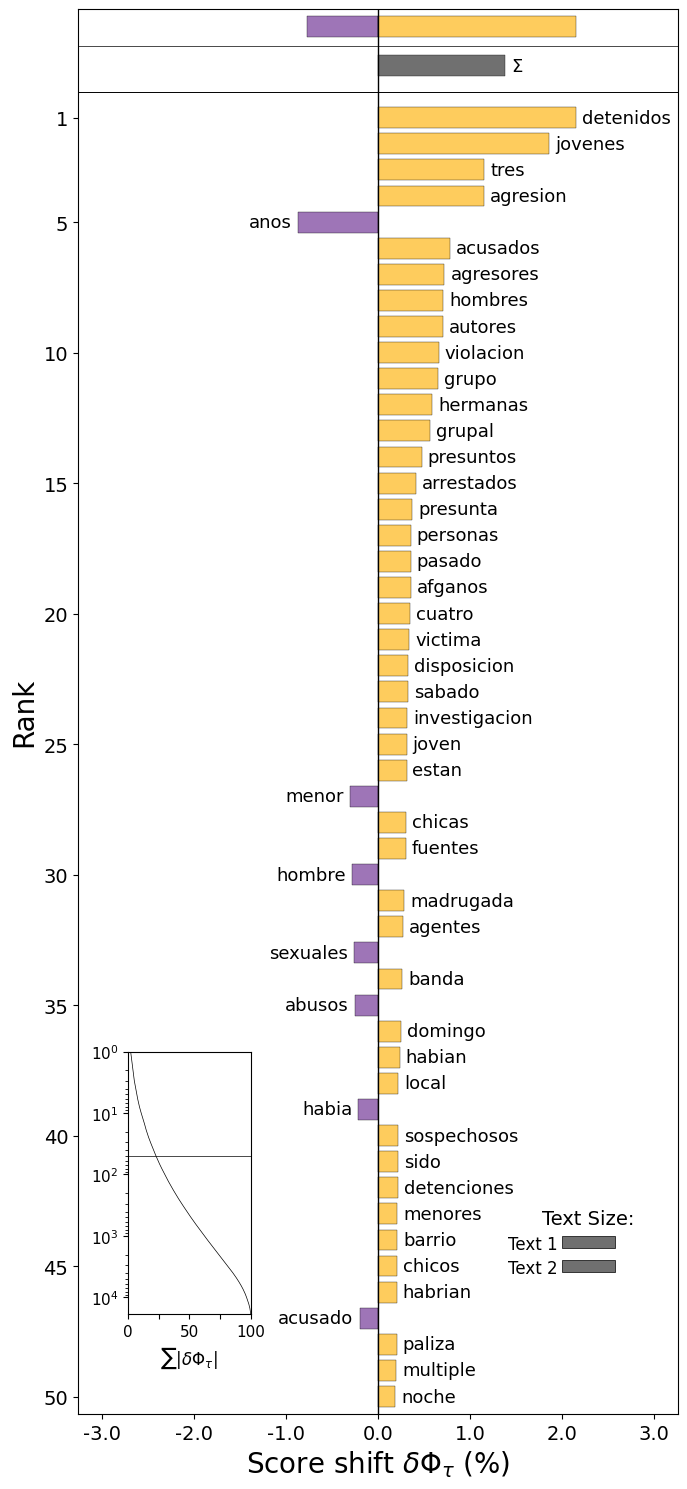

In [14]:
# Get the set of types (words) that appear in both type2freq_0 and type2freq_1
common_types = set(type2freq_0.keys()).intersection(set(type2freq_1.keys()))

# Filter type2freq_0 and type2freq_1 to only include the common types
type2freq_0_filtered = {t: type2freq_0[t] for t in common_types}
type2freq_1_filtered = {t: type2freq_1[t] for t in common_types}

# Create a KLDivergenceShift object with the filtered type2freq dictionaries
kld_shift = sh.KLDivergenceShift(type2freq_1=type2freq_0_filtered, type2freq_2=type2freq_1_filtered, base=2)

# Generate the shift graph
shift_graph = kld_shift.get_shift_graph()

In [15]:
kld_shift.diff

0.4350967773240039

5. Jensen-Shannon Divergence Shifts (Cambios en la Divergencia de Jensen-Shannon): La Divergencia de Jensen-Shannon (JS) es otra medida que cuantifica la diferencia entre dos distribuciones de probabilidad. Es una versión suavizada y simétrica de la Divergencia de Kullback-Leibler. Los cambios en la Divergencia de JS proporcionan una medida de la distancia y el cambio entre las distribuciones de datos y referencia.

/Users/martagracia/Library/Python/3.9/lib/python/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


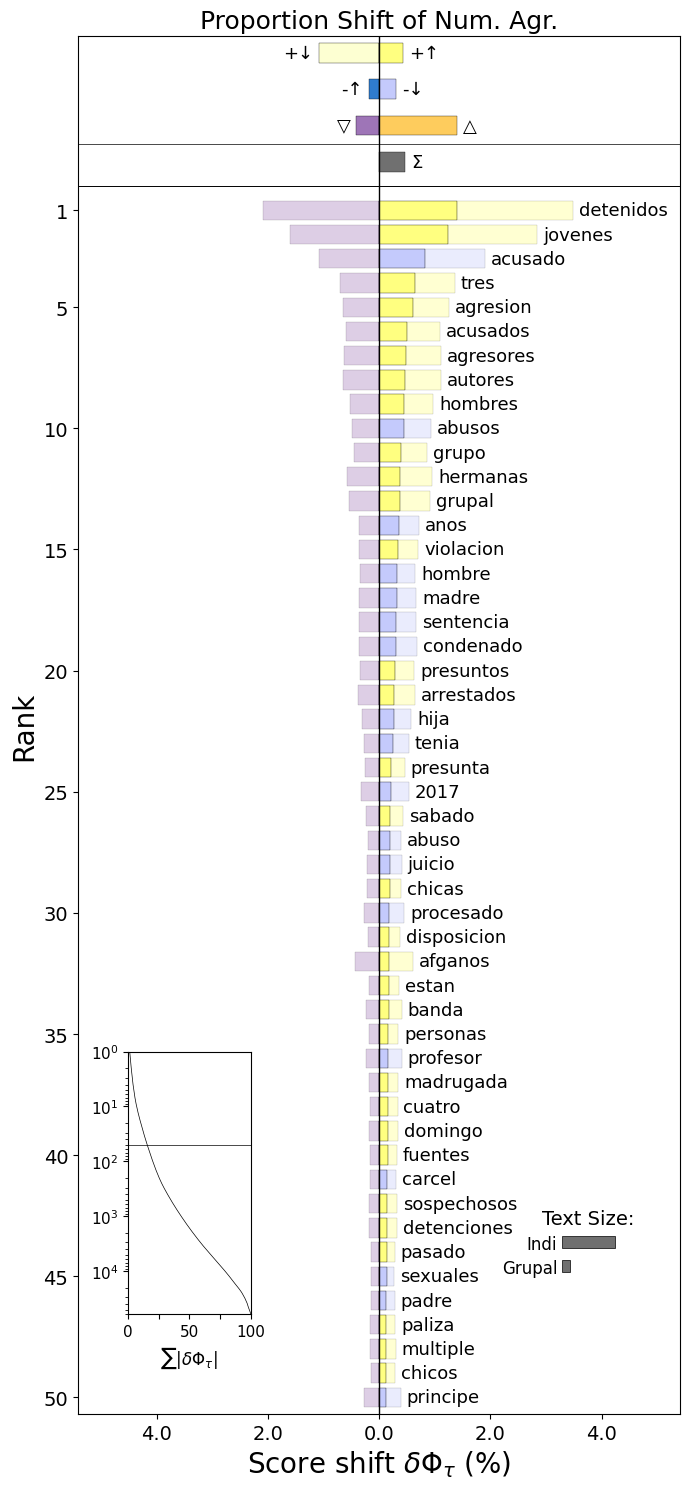

<AxesSubplot: title={'center': 'Proportion Shift of Num. Agr.'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [16]:
jsd_shift = sh.JSDivergenceShift(type2freq_1=type2freq_0,
                                 type2freq_2=type2freq_1,
                                 weight_1=0.5,
                                 weight_2=0.5,
                                 base=2,
                                 alpha=1)
jsd_shift.get_shift_graph(detailed=True, system_names=['Indi', 'Grupal'], title='Proportion Shift of Num. Agr.')

# NLP Tags (ADJ, ADV, Noun, Verb)

In [9]:
def extract_adj_adv_nn_verb(text):
    nlp = spacy.load('/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/es_core_news_sm/es_core_news_sm-3.5.0')
    doc = nlp(text)

    adj = []
    adv = []
    nn = []
    verb = []

    for token in doc:
        if token.pos_ == 'ADJ':
            adj.append(token.text)
        elif token.pos_ == 'ADV':
            adv.append(token.text)
        elif token.pos_ == 'NOUN':
            nn.append(token.text)
        elif token.pos_ == 'VERB':
            verb.append(token.text)

    max_length = max(len(adj), len(adv), len(nn), len(verb))
    padded_data = {
        'adj': adj + [None] * (max_length - len(adj)),
        'adv': adv + [None] * (max_length - len(adv)),
        'nn': nn + [None] * (max_length - len(nn)),
        'verb': verb + [None] * (max_length - len(verb))
    }

    return pd.Series(padded_data)

def shiferator(df1, df2, tag):
    df1 = sum(df1[tag].apply(ast.literal_eval).values, [])
    df2 = sum(df2[tag].apply(ast.literal_eval).values, [])
    
    # Filtrar la palabra "name"
    df1 = list(filter(lambda x: x not in ['name', None], df1))
    df2 = list(filter(lambda x: x not in ['name', None], df2))
    
    type2freq_df1 = Counter(df1)
    type2freq_df2 = Counter(df2)

    entropy_shift = sh.EntropyShift(type2freq_1=type2freq_df1,
                                    type2freq_2=type2freq_df2,
                                    reference_value='average')
    return entropy_shift

#### TIPUS D'AGRESIÓ: INDIVIDUAL (0) - GRUPAL (1)

In [19]:
# Tokenize and preprocess the text
result_0 = label_0['text'].apply(extract_adj_adv_nn_verb)
label_0[['adj', 'adv', 'nn', 'verb']] = result_0
label_0.to_csv('agr_label_0_NLP.csv')

"\nresult_0 = label_0['text'].apply(extract_adj_adv_nn_verb)\nlabel_0[['adj', 'adv', 'nn', 'verb']] = result_0\nlabel_0.to_csv('agr_label_0_NLP.csv')\n"

In [20]:

result_1 = label_1['text'].apply(extract_adj_adv_nn_verb)
label_1[['adj', 'adv', 'nn', 'verb']] = result_1
label_1.to_csv('agr_label_1_NLP.csv')


"\nresult_1 = label_1['text'].apply(extract_adj_adv_nn_verb)\nlabel_1[['adj', 'adv', 'nn', 'verb']] = result_1\nlabel_1.to_csv('agr_label_1_NLP.csv')\n"

In [1]:
import pandas as pd
label_0 = pd.read_csv('agr_label_0_NLP.csv', index_col=0)
label_1 = pd.read_csv('agr_label_1_NLP.csv', index_col=0)

In [3]:
label_1.head()

,text,label_predict,text_tokenized,adj,adv,nn,verb
2,name 3 jovenes acusados violar 3 hermanas esta...,1,"['jovenes', 'acusados', 'violar', 'hermanas', ...","['acusados', 'estadounidenses', 'name', 'name'...","[None, None, None, None, None, None, None, Non...","['jovenes', 'hermanas', 'jueves', 'jovenes', '...","['name', 'violar', 'name', 'name', 'name', 'na..."
6,name provisional tres jovenes acusados violar ...,1,"['provisional', 'tres', 'jovenes', 'acusados',...","['provisional', 'acusados', 'estadounidenses',...","['sexualmente', 'tsj', 'recientemente', None, ...","['jovenes', 'hermanas', 'name', 'titular', 'nu...","['name', 'violar', 'name', 'name', 'name', 'fi..."
10,name dos menores violacion grupal menor 14 ano...,1,"['menores', 'violacion', 'grupal', 'menor', 'a...","['menores', 'grupal', 'menor', 'name', 'name',...","['presuntamente', 'presuntamente', 'explico', ...","['violacion', 'anos', 'violacion', 'anos', 'jo...","['name', 'name', 'name', 'participar', 'name',..."
14,name name investiga si existe grabacion violac...,1,"['investiga', 'existe', 'grabacion', 'violacio...","['grupal', 'menor', 'name', 'name', 'presunta'...","['tambien', 'bien', 'realmente', None, None, N...","['name', 'name', 'agresion', 'nina', 'anos', '...","['name', 'investiga', 'existe', 'name', 'name'..."
16,name menor implicada violacion grupal nina 13 ...,1,"['menor', 'implicada', 'violacion', 'grupal', ...","['menor', 'implicada', 'grupal', 'informado', ...","['tarde', 'presuntamente', 'presuntamente', No...","['violacion', 'anos', 'name', 'detencion', 'vi...","['name', 'nina', 'name', 'name', 'name', 'name..."


##### ADJECTIVE

In [10]:
adj_shift = shiferator(label_0, label_1, 'adj')

/Users/martagracia/Library/Python/3.9/lib/python/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


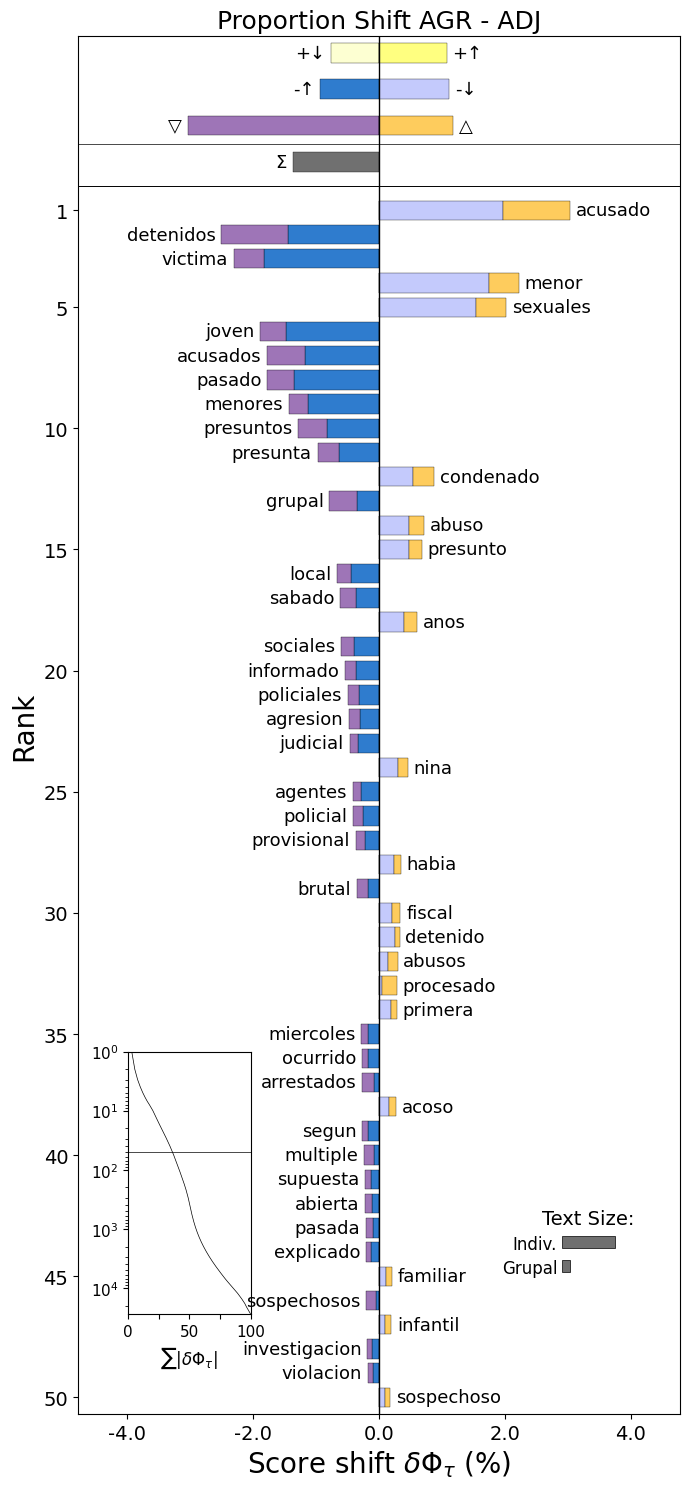

<AxesSubplot: title={'center': 'Proportion Shift AGR - ADJ'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [13]:
adj_shift.get_shift_graph(detailed=True, system_names=['Indiv.', 'Grupal'], title='Proportion Shift AGR - ADJ')

##### ADVERBI

In [25]:
adv_shift = shiferator(label_0, label_1, 'adv')

/Users/martagracia/Library/Python/3.9/lib/python/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


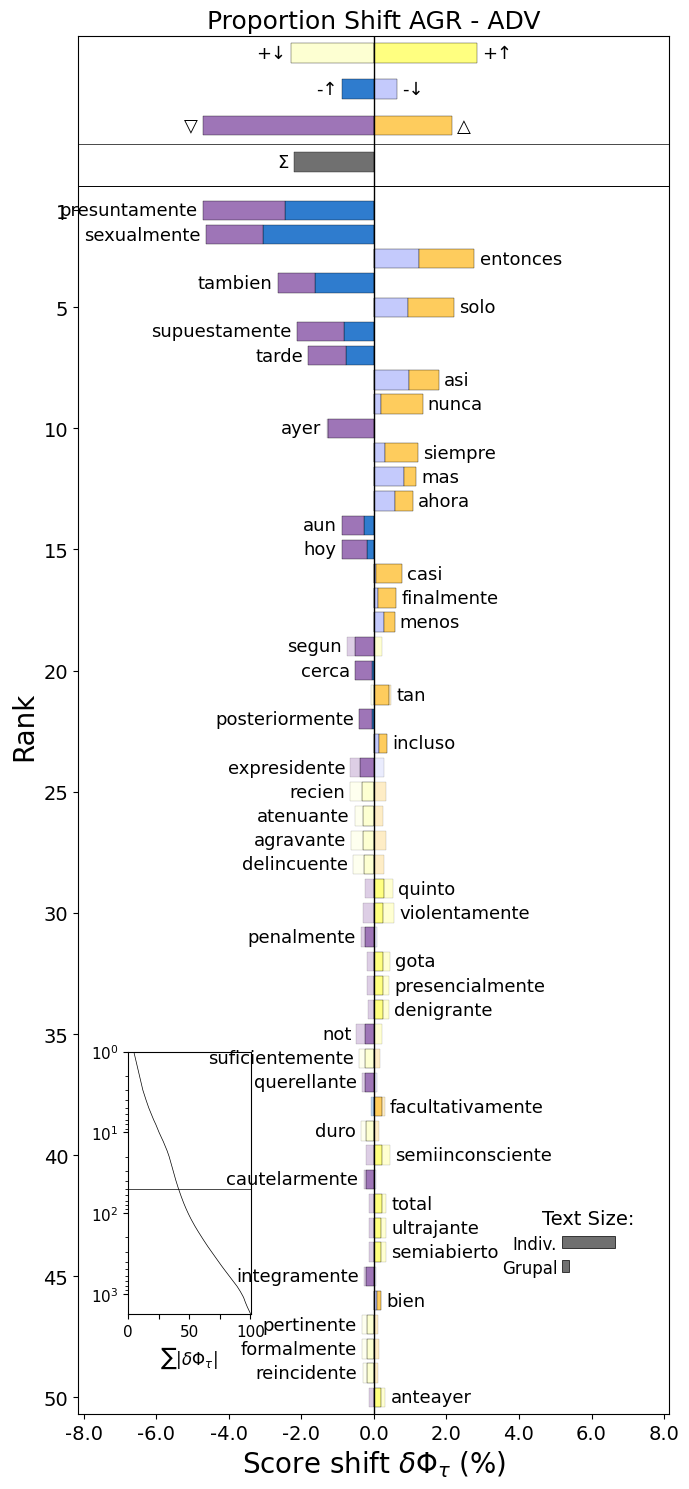

<AxesSubplot: title={'center': 'Proportion Shift AGR - ADV'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [26]:
adv_shift.get_shift_graph(detailed=True, system_names=['Indiv.', 'Grupal'], title='Proportion Shift AGR - ADV')

##### NOUN

In [27]:
nn_shift = shiferator(label_0, label_1, 'nn')

/Users/martagracia/Library/Python/3.9/lib/python/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


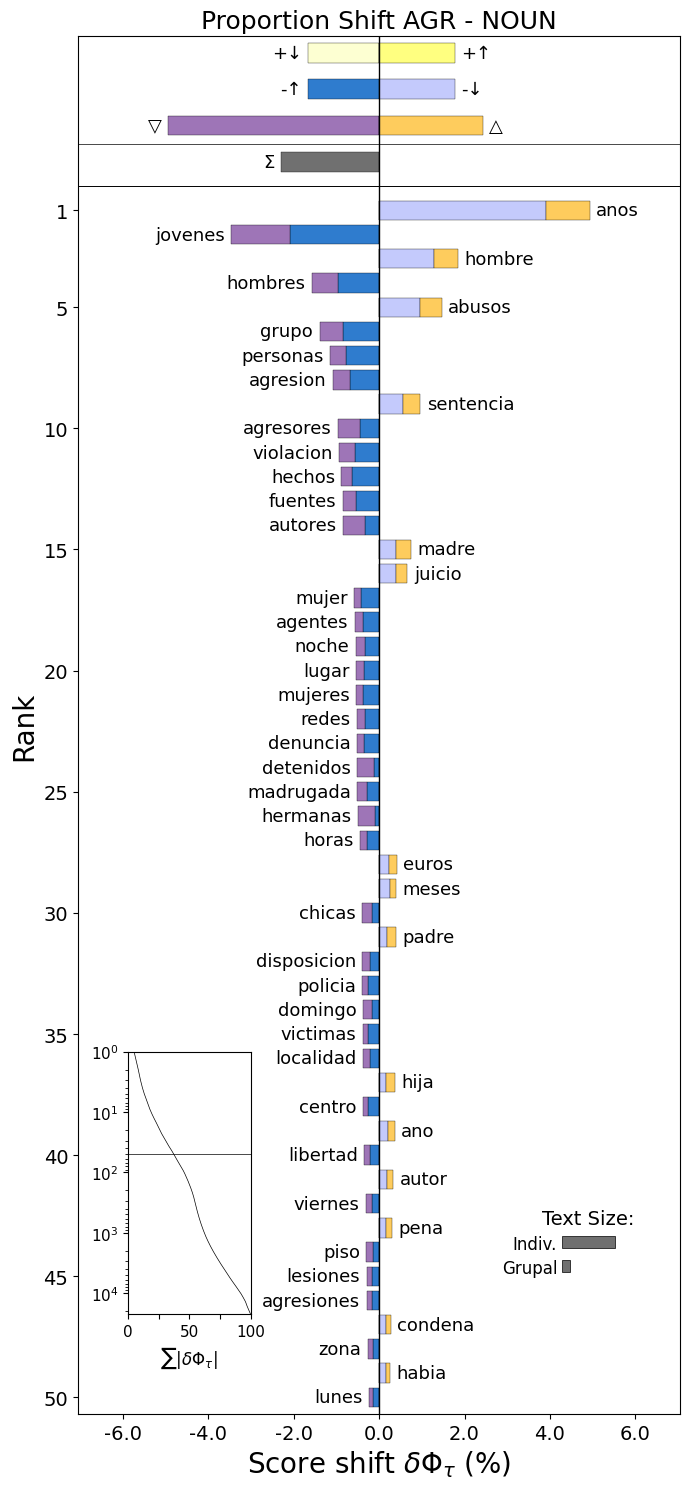

<AxesSubplot: title={'center': 'Proportion Shift AGR - NOUN'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [28]:
nn_shift.get_shift_graph(detailed=True, system_names=['Indiv.', 'Grupal'], title='Proportion Shift AGR - NOUN')

##### VERB

In [29]:
verb_shift = shiferator(label_0, label_1, 'verb')

/Users/martagracia/Library/Python/3.9/lib/python/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


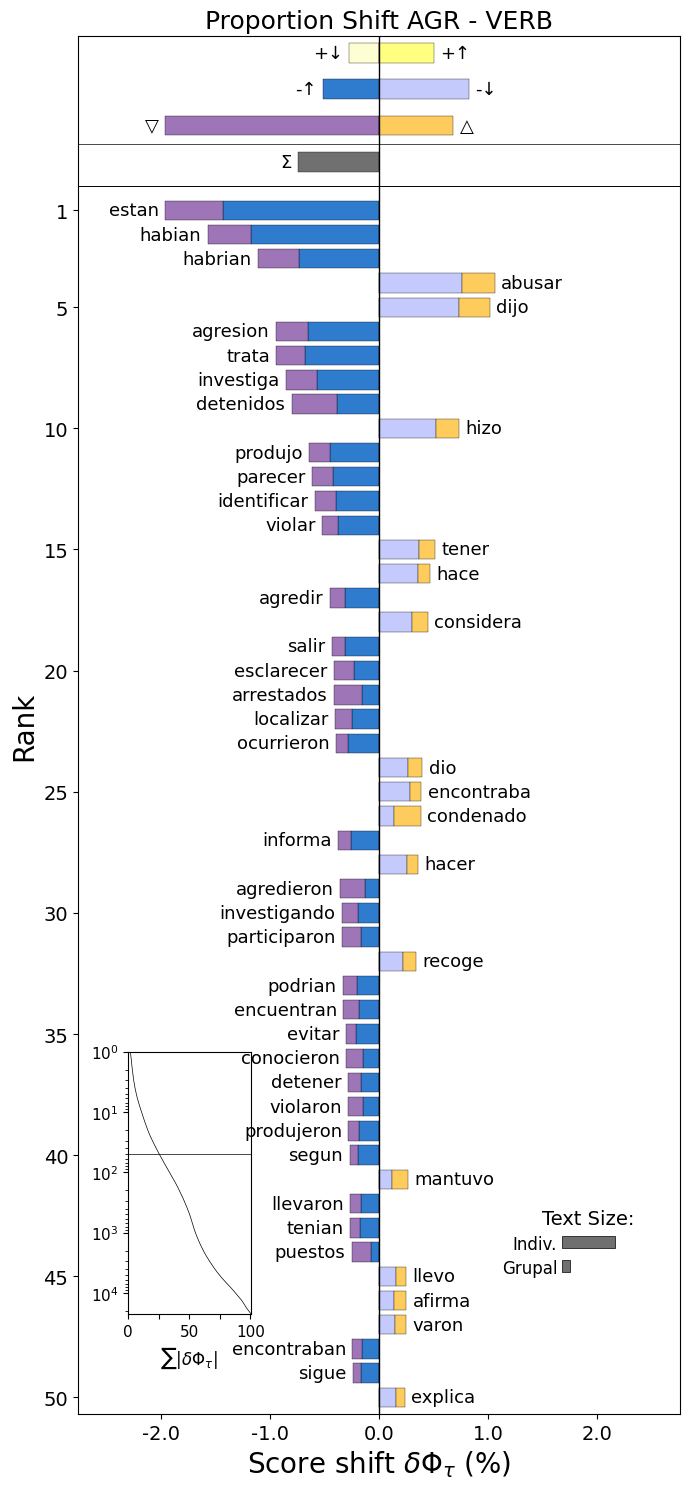

<AxesSubplot: title={'center': 'Proportion Shift AGR - VERB'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [30]:
verb_shift.get_shift_graph(detailed=True, system_names=['Indiv.', 'Grupal'], title='Proportion Shift AGR - VERB')

#### TIPUS DE RELACIÓ: 

In [31]:
articles_rel_proba = pd.read_csv('../articles_classification/articles_rel_proba.csv', index_col=0)
articles_rel_proba.head()

,tweet_id,media,title,headline,url,article,publication_date,text,prob_desc,prob_pareja,prob_familiar,prob_conocido,label_predict
0,1212203735650328577,20m,name britanica detenida falso testimonio tras ...,name joven britanica 19 anos mes julio detenida,https://www.20minutos.es/noticia/4102525/0/cul...,name joven britanica 19 anos mes julio detenid...,2019-12-31,name britanica detenida falso testimonio tras ...,0.906272,0.058222,0.018151,0.017355,0
1,1212467642428280832,20m,name parto nina 13 anos violada padre,name name nina brasilena 13 anos fallecio comi...,https://www.20minutos.es/noticia/4103250/0/mue...,name name nina brasilena 13 anos fallecio comi...,2020-01-01,name parto nina 13 anos violada padre name nam...,0.058545,0.084664,0.837165,0.019626,2
2,1212826760234127360,20m,name 3 jovenes acusados violar 3 hermanas esta...,name name name detenido jueves tres jovenes ac...,https://www.20minutos.es/noticia/4104199/0/det...,name name name detenido jueves tres jovenes ac...,2020-01-02,name 3 jovenes acusados violar 3 hermanas esta...,0.904977,0.030287,0.040715,0.024021,0
3,1213232973715267584,20m,name claves name juicio name name abusos sexua...,name juicio supuestos abusos sexuales todopode...,https://www.20minutos.es/noticia/4105188/0/cla...,name juicio supuestos abusos sexuales todopode...,2020-01-03,name claves name juicio name name abusos sexua...,0.106185,0.046487,0.028328,0.819001,3
4,1213348259076415488,20m,name name name investiga escritor frances name...,name name name abierto viernes investigacion e...,https://www.20minutos.es/noticia/4104916/0/fra...,name name name abierto viernes investigacion e...,2020-01-03,name name name investiga escritor frances name...,0.589247,0.375221,0.024869,0.010662,0


In [32]:
articles_rel = articles_rel_proba[articles_rel_proba['label_predict'] != 3]
articles_rel = articles_rel[['text', 'label_predict']]

In [33]:
# Split the DataFrame based on the label
# Desconocido
rel_label_0 = articles_rel[articles_rel['label_predict']==0]
# (Ex)Pareja
rel_label_1 = articles_rel[articles_rel['label_predict']==1]
# Familiar
rel_label_2 = articles_rel[articles_rel['label_predict']==2]

##### (EX)PARELLA: NO (0) - SI (1)

In [34]:
"""
rel_0 = rel_label_0['text'].apply(extract_adj_adv_nn_verb)
rel_label_0[['adj', 'adv', 'nn', 'verb']] = rel_0
rel_label_0.to_csv('rel_label_0_NLP.csv')
"""

/var/folders/8y/kdv5k1ks43v38hl9433hbqsr0000gn/T/ipykernel_13689/2973593526.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_label_0[['adj', 'adv', 'nn', 'verb']] = rel_0
/var/folders/8y/kdv5k1ks43v38hl9433hbqsr0000gn/T/ipykernel_13689/2973593526.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_label_0[['adj', 'adv', 'nn', 'verb']] = rel_0
/var/folders/8y/kdv5k1ks43v38hl9433hbqsr0000gn/T/ipykernel_13689/2973593526.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [36]:
"""
rel_1 = rel_label_1['text'].apply(extract_adj_adv_nn_verb)
rel_label_1[['adj', 'adv', 'nn', 'verb']] = rel_1
rel_label_1.to_csv('rel_label_1_NLP.csv')
"""

/var/folders/8y/kdv5k1ks43v38hl9433hbqsr0000gn/T/ipykernel_13689/1232270063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_label_1[['adj', 'adv', 'nn', 'verb']] = rel_1
/var/folders/8y/kdv5k1ks43v38hl9433hbqsr0000gn/T/ipykernel_13689/1232270063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_label_1[['adj', 'adv', 'nn', 'verb']] = rel_1
/var/folders/8y/kdv5k1ks43v38hl9433hbqsr0000gn/T/ipykernel_13689/1232270063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [37]:
rel_label_0 = pd.read_csv('rel_label_0_NLP.csv', index_col=0)
rel_label_1 = pd.read_csv('rel_label_1_NLP.csv', index_col=0)

ADJECTIVE

/Users/martagracia/Library/Python/3.9/lib/python/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


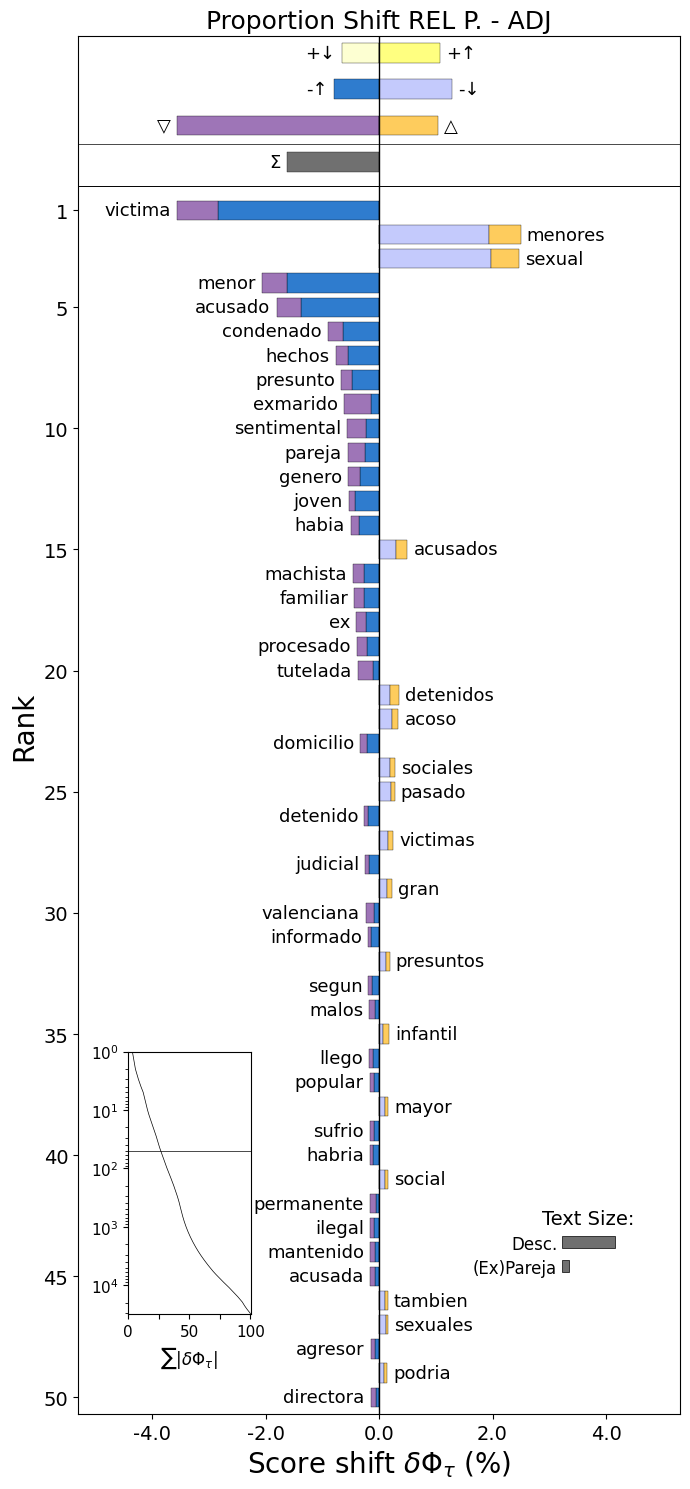

<AxesSubplot: title={'center': 'Proportion Shift REL P. - ADJ'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [38]:
adj_rel_shift = shiferator(rel_label_0, rel_label_1, 'adj')
adj_rel_shift.get_shift_graph(detailed=True, system_names=['Desc.', '(Ex)Pareja'], title='Proportion Shift REL P. - ADJ')

ADVERB

/Users/martagracia/Library/Python/3.9/lib/python/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


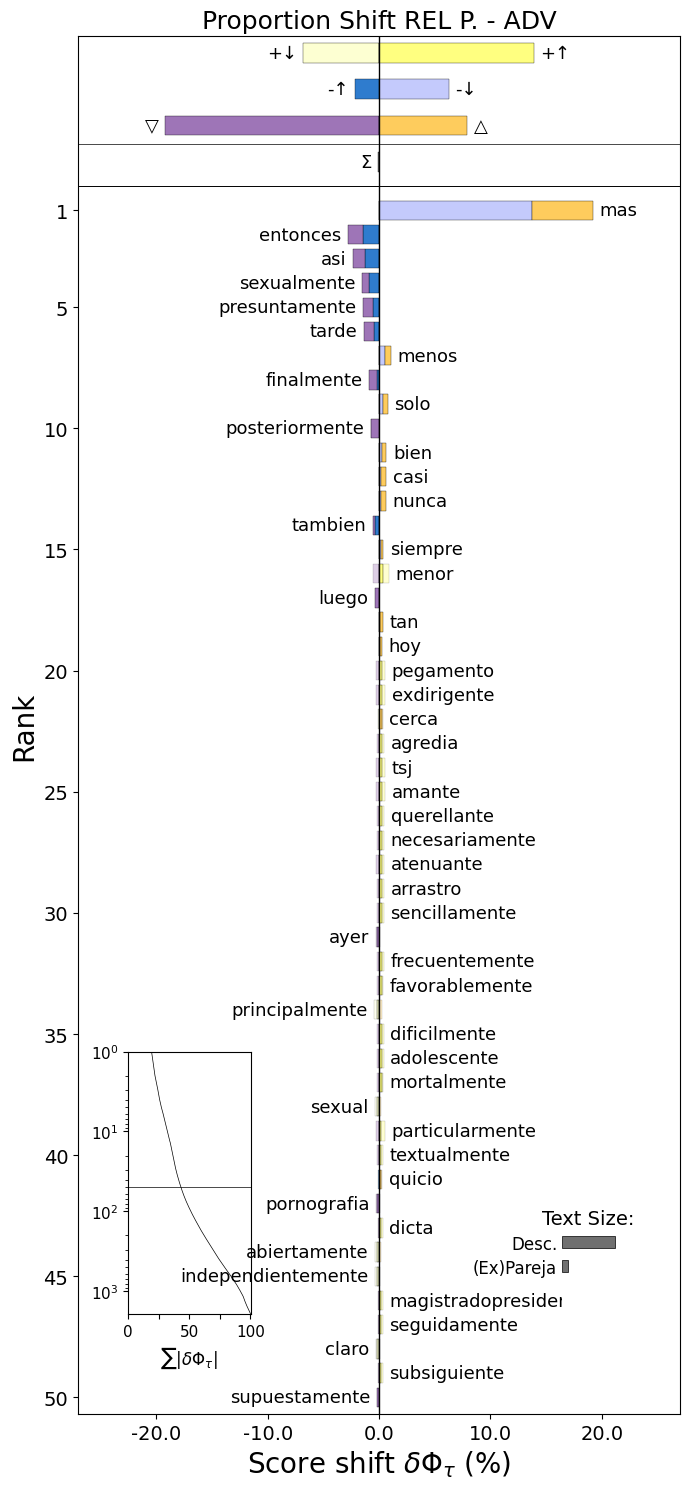

<AxesSubplot: title={'center': 'Proportion Shift REL P. - ADV'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [39]:
adv_rel_shift = shiferator(rel_label_0, rel_label_1, 'adv')
adv_rel_shift.get_shift_graph(detailed=True, system_names=['Desc.', '(Ex)Pareja'], title='Proportion Shift REL P. - ADV')

NOUN

/Users/martagracia/Library/Python/3.9/lib/python/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


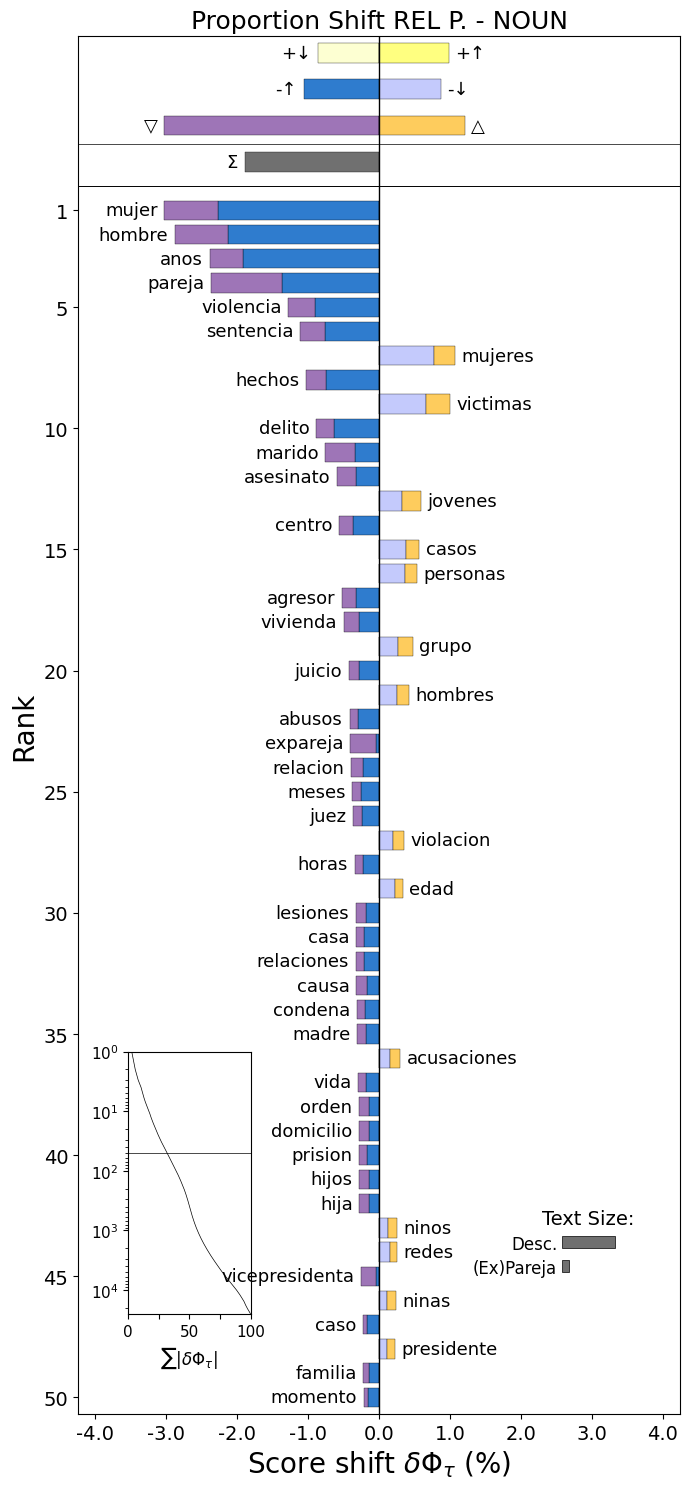

<AxesSubplot: title={'center': 'Proportion Shift REL P. - NOUN'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [40]:
nn_rel_shift = shiferator(rel_label_0, rel_label_1, 'nn')
nn_rel_shift.get_shift_graph(detailed=True, system_names=['Desc.', '(Ex)Pareja'], title='Proportion Shift REL P. - NOUN')

VERB

/Users/martagracia/Library/Python/3.9/lib/python/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


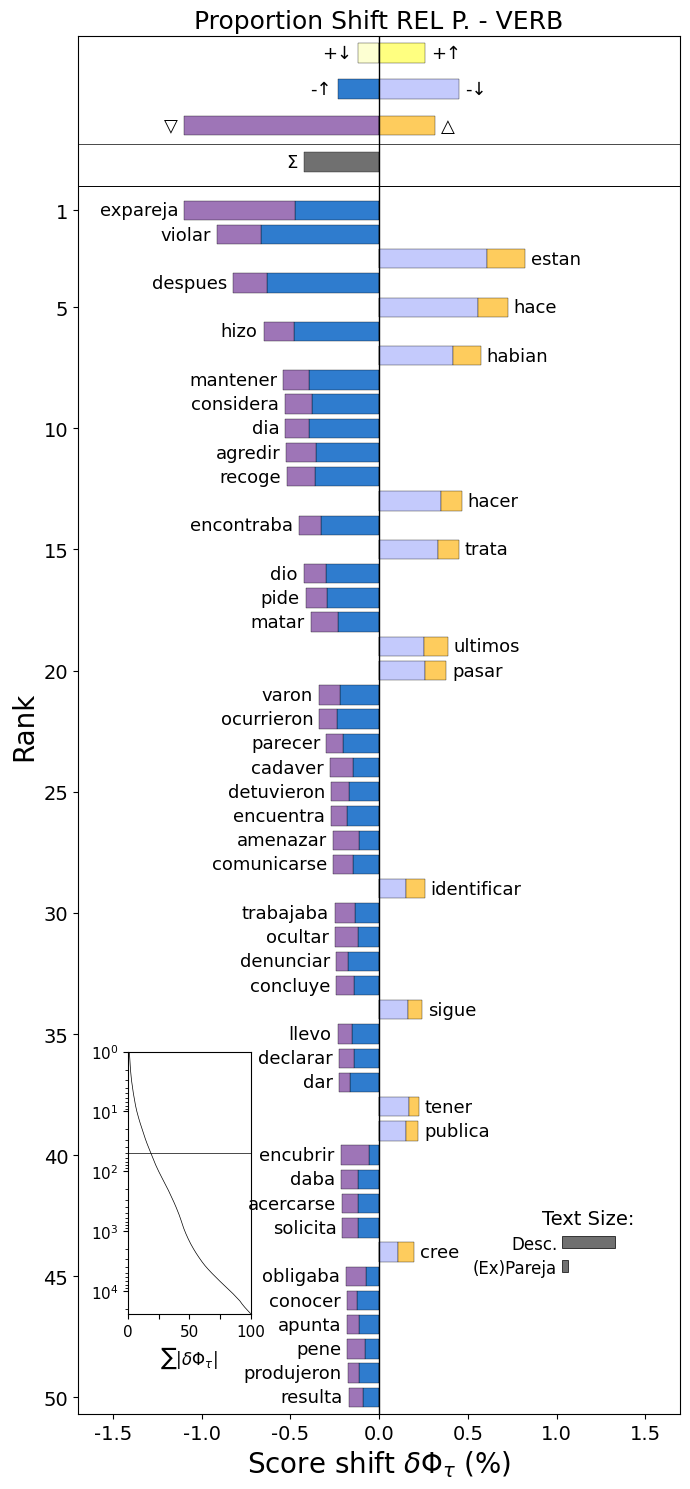

<AxesSubplot: title={'center': 'Proportion Shift REL P. - VERB'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [41]:
verb_rel_shift = shiferator(rel_label_0, rel_label_1, 'verb')
verb_rel_shift.get_shift_graph(detailed=True, system_names=['Desc.', '(Ex)Pareja'], title='Proportion Shift REL P. - VERB')

##### FAMILIAR: NO (0) - SI (1)

In [42]:
rel_2 = rel_label_2['text'].apply(extract_adj_adv_nn_verb)
rel_label_2[['adj', 'adv', 'nn', 'verb']] = rel_2
rel_label_2.to_csv('rel_label_2_NLP.csv')

/var/folders/8y/kdv5k1ks43v38hl9433hbqsr0000gn/T/ipykernel_13689/988720408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_label_2[['adj', 'adv', 'nn', 'verb']] = rel_2
/var/folders/8y/kdv5k1ks43v38hl9433hbqsr0000gn/T/ipykernel_13689/988720408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_label_2[['adj', 'adv', 'nn', 'verb']] = rel_2
/var/folders/8y/kdv5k1ks43v38hl9433hbqsr0000gn/T/ipykernel_13689/988720408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [43]:
rel_label_2 = pd.read_csv('rel_label_2_NLP.csv', index_col=0)

ADJECTIVE

/Users/martagracia/Library/Python/3.9/lib/python/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


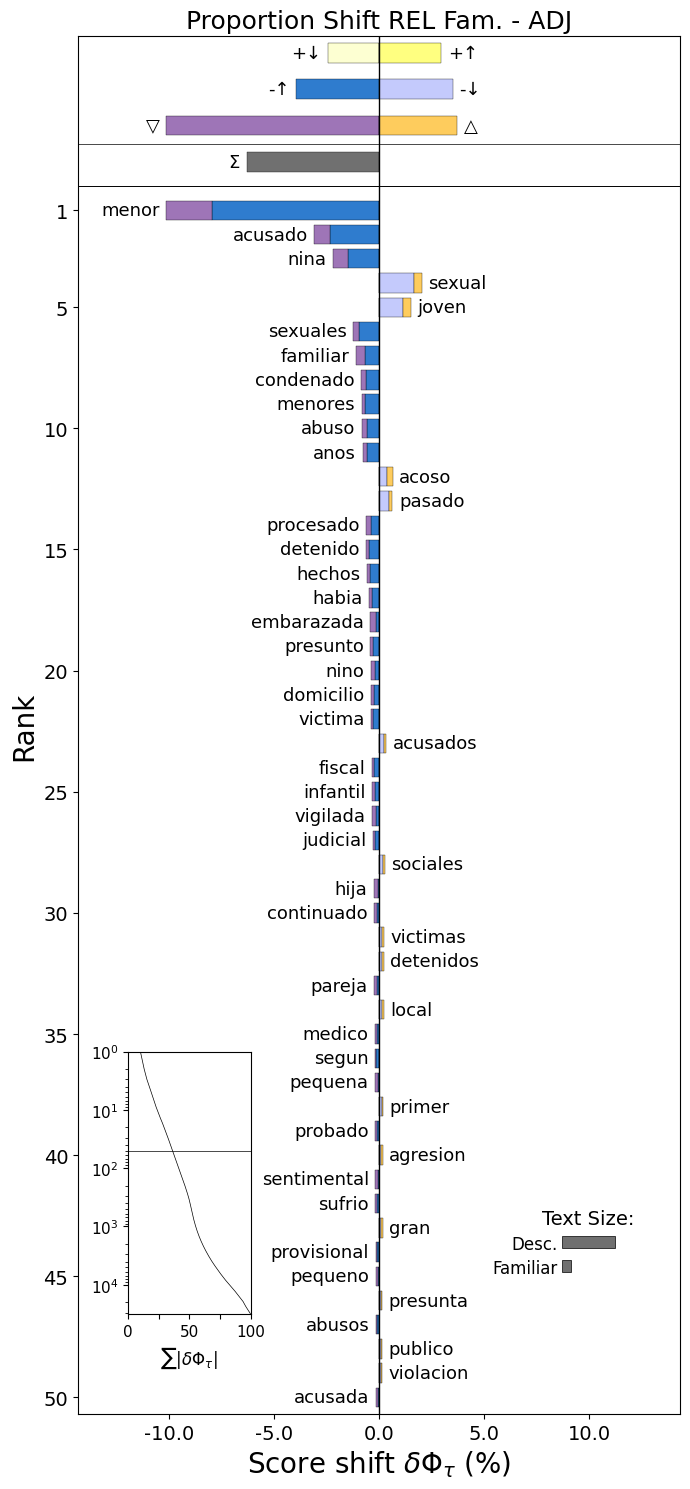

<AxesSubplot: title={'center': 'Proportion Shift REL Fam. - ADJ'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [44]:
adj_rel_shift = shiferator(rel_label_0, rel_label_2, 'adj')
adj_rel_shift.get_shift_graph(detailed=True, system_names=['Desc.', 'Familiar'], title='Proportion Shift REL Fam. - ADJ')

ADVERB

/Users/martagracia/Library/Python/3.9/lib/python/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


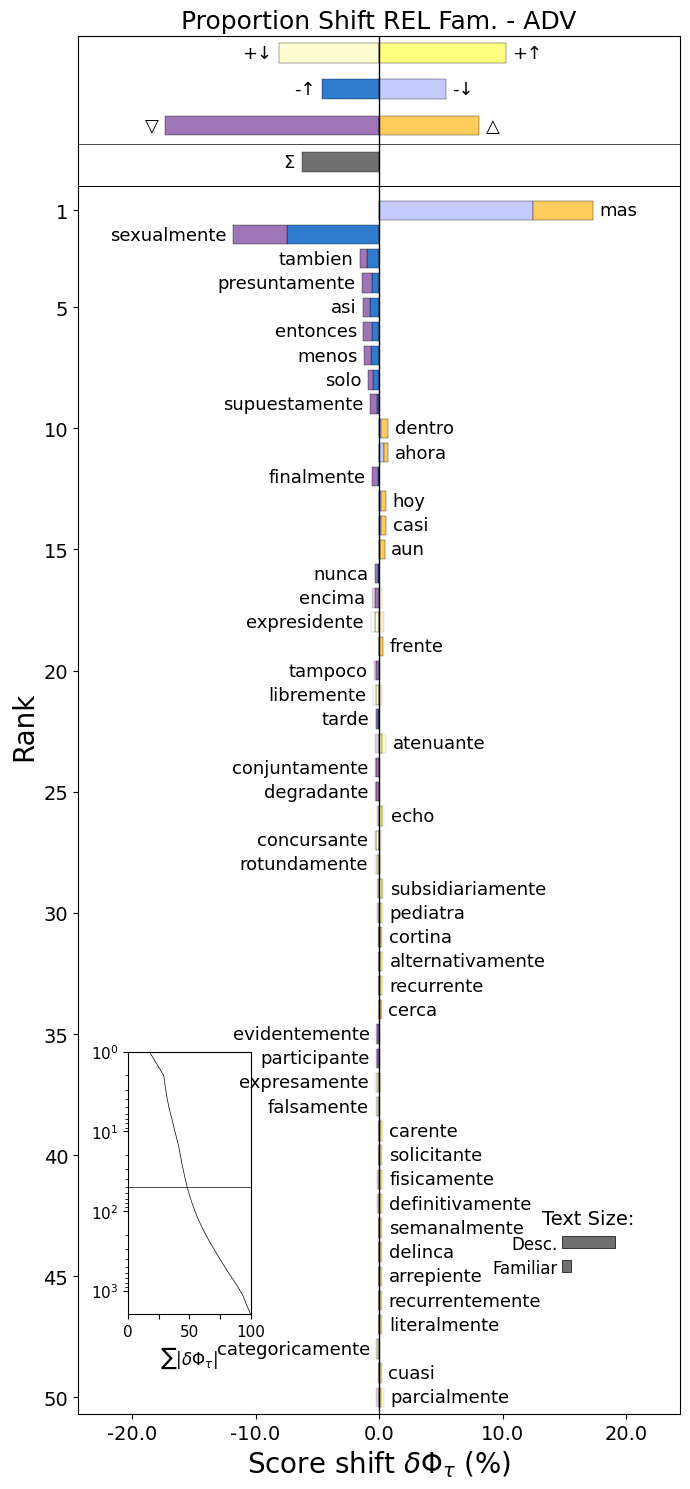

<AxesSubplot: title={'center': 'Proportion Shift REL Fam. - ADV'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [45]:
adv_rel_shift = shiferator(rel_label_0, rel_label_2, 'adv')
adv_rel_shift.get_shift_graph(detailed=True, system_names=['Desc.', 'Familiar'], title='Proportion Shift REL Fam. - ADV')

NOUN

/Users/martagracia/Library/Python/3.9/lib/python/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


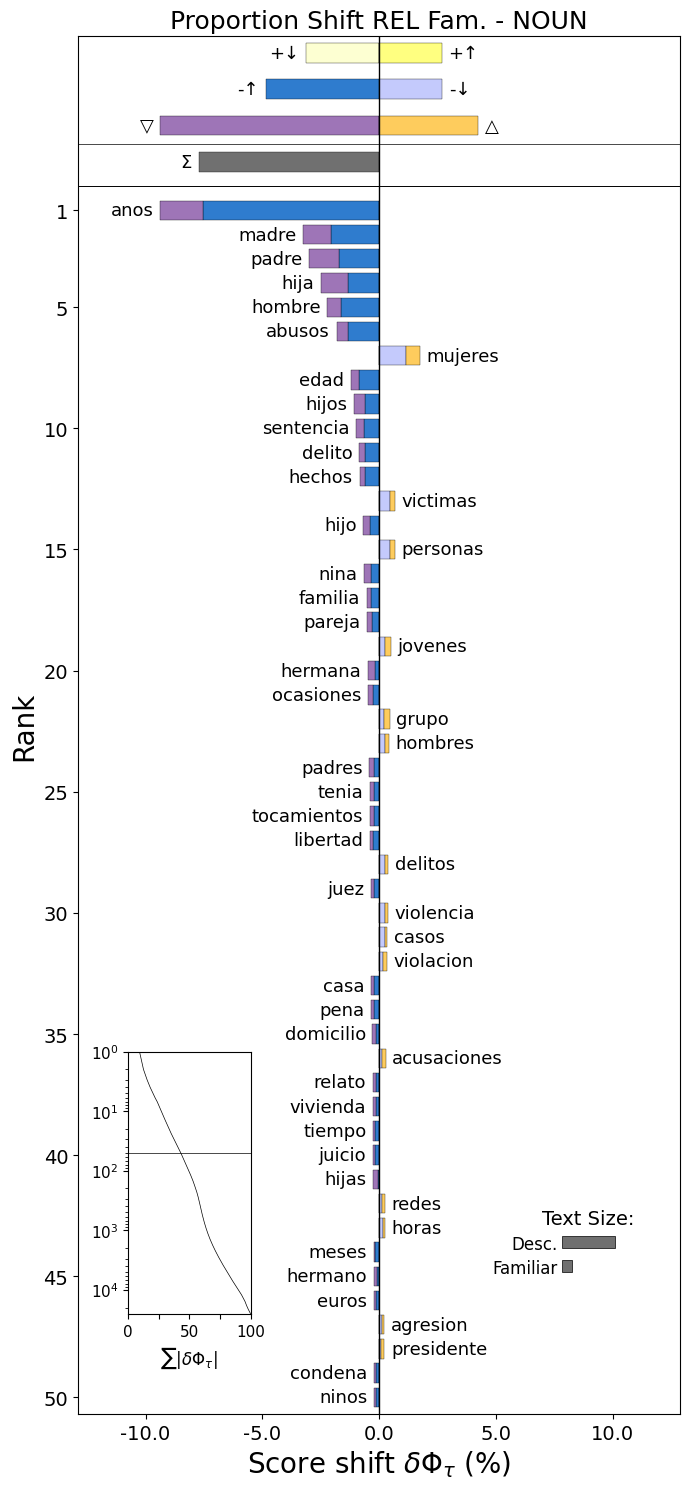

<AxesSubplot: title={'center': 'Proportion Shift REL Fam. - NOUN'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [46]:
nn_rel_shift = shiferator(rel_label_0, rel_label_2, 'nn')
nn_rel_shift.get_shift_graph(detailed=True, system_names=['Desc.', 'Familiar'], title='Proportion Shift REL Fam. - NOUN')

VERB

/Users/martagracia/Library/Python/3.9/lib/python/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


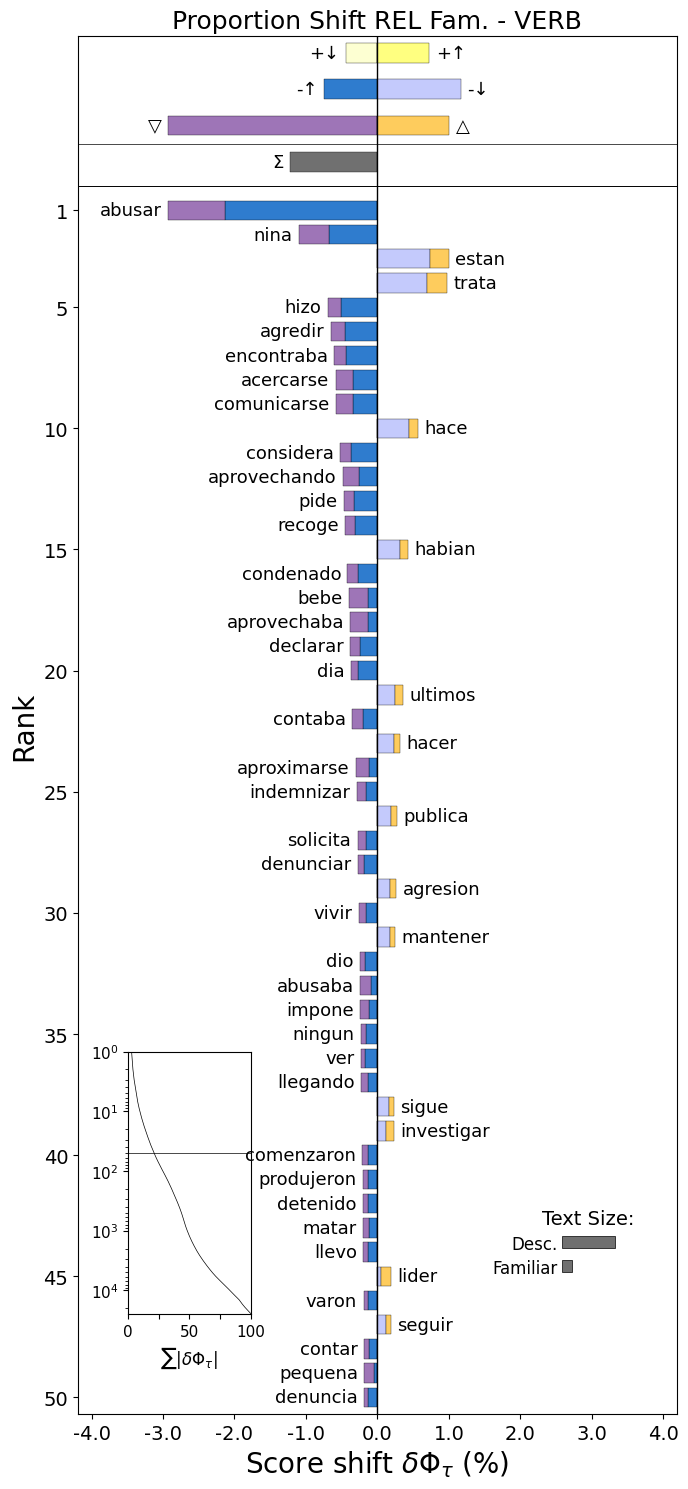

<AxesSubplot: title={'center': 'Proportion Shift REL Fam. - VERB'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [47]:
verb_rel_shift = shiferator(rel_label_0, rel_label_2, 'verb')
verb_rel_shift.get_shift_graph(detailed=True, system_names=['Desc.', 'Familiar'], title='Proportion Shift REL Fam. - VERB')